<a href="https://colab.research.google.com/github/IbrahimEnouali/EC-DataScience-Coursework/blob/main/Big-Data/PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=b9dd59459c4a965ea7cd67effa1ebf322c0d2003597bf32e3931db35baeeac93
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [ ]:
#Start spark session
spark = SparkSession.builder.appName("TP_spark").getOrCreate()

In [ ]:
directory_path = '/content/drive/MyDrive/Datalake/01_RawData/'
df = spark.read.csv(directory_path + "valeursfoncieres-*.txt", header=True, sep="|")

In [ ]:
df.printSchema()

root
 |-- Identifiant de document: string (nullable = true)
 |-- Reference document: string (nullable = true)
 |-- 1 Articles CGI: string (nullable = true)
 |-- 2 Articles CGI: string (nullable = true)
 |-- 3 Articles CGI: string (nullable = true)
 |-- 4 Articles CGI: string (nullable = true)
 |-- 5 Articles CGI: string (nullable = true)
 |-- No disposition: string (nullable = true)
 |-- Date mutation: string (nullable = true)
 |-- Nature mutation: string (nullable = true)
 |-- Valeur fonciere: string (nullable = true)
 |-- No voie: string (nullable = true)
 |-- B/T/Q: string (nullable = true)
 |-- Type de voie: string (nullable = true)
 |-- Code voie: string (nullable = true)
 |-- Voie: string (nullable = true)
 |-- Code postal: string (nullable = true)
 |-- Commune: string (nullable = true)
 |-- Code departement: string (nullable = true)
 |-- Code commune: string (nullable = true)
 |-- Prefixe de section: string (nullable = true)
 |-- Section: string (nullable = true)
 |-- No plan: s

In [ ]:
#Select only variables needed
new_df = df.select(['Date mutation', 'Valeur fonciere', 'Type local'])

In [ ]:
# Convert the 'Date mutation' column to a real date
new_df = new_df.withColumn("Date mutation", F.to_date(new_df["Date mutation"], "dd/MM/yyyy"))

In [ ]:
# Extract the year from the date and put it in a column called Year
new_df = new_df.withColumn("Year", F.year(new_df["Date mutation"]))

In [ ]:
#Drop Date mutation
new_df = new_df.drop('Date mutation')

In [ ]:
#Filter on Type local and let only Maison and Appartement
new_df = new_df.filter((new_df['Type local']=='Maison')|(new_df['Type local']=='Appartement'))

In [ ]:
#Remove null values in Valeur fonciere
new_df = new_df.na.drop(subset='Valeur fonciere')

In [ ]:
#Change Valeur fonciere data type from string to float
new_df = new_df.withColumn('Valeur fonciere', F.regexp_replace('Valeur fonciere', ',', '.'))
new_df = new_df.withColumn('Valeur fonciere', new_df['Valeur fonciere'].cast('float'))

In [ ]:
df_distribution = new_df.groupBy('Type local')\
                          .agg(F.count('Valeur fonciere').alias('Count'),\
                              F.avg('Valeur fonciere').alias('Mean'),\
                              F.stddev('Valeur fonciere').alias('Stddev'),\
                              F.min('Valeur fonciere').alias('Min'),\
                              F.max('Valeur fonciere').alias('Max'))

In [ ]:
df_distribution.show()

+-----------+-------+-----------------+--------------------+----+----------+
| Type local|  Count|             Mean|              Stddev| Min|       Max|
+-----------+-------+-----------------+--------------------+----+----------+
|Appartement|2545727|4456286.911539782|2.9547787403763246E7|0.15|6.062103E8|
|     Maison|2998667|665314.3210680179|   8794170.569120314|0.15|   2.086E9|
+-----------+-------+-----------------+--------------------+----+----------+



In [ ]:
#Filter out 2020 and 2021
new_df_filtered = new_df.filter((new_df['Year']=='2019')|(new_df['Year']=='2022'))

In [ ]:
pivoted_df = new_df_filtered\
              .groupBy("Year")\
              .pivot("Type local")\
              .sum("Valeur fonciere")\
              .orderBy("Year")

In [ ]:
pivoted_df.show()

+----+--------------------+--------------------+
|Year|         Appartement|              Maison|
+----+--------------------+--------------------+
|2019|1.628899007611708...|4.870511850371363...|
|2022|5.330347113940935E12|5.767673634423651E11|
+----+--------------------+--------------------+



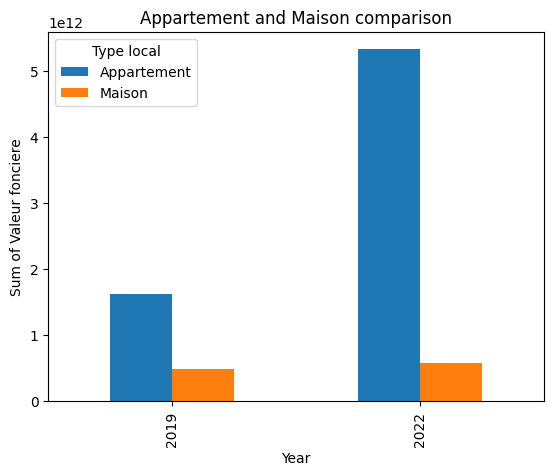

In [ ]:
import matplotlib.pyplot as plt
pandas_df = pivoted_df.toPandas()
pandas_df.plot(kind='bar', x='Year', y=['Appartement', 'Maison'])
plt.xlabel('Year')
plt.ylabel('Sum of Valeur fonciere')
plt.title('Appartement and Maison comparison')
plt.legend(title='Type local')
plt.show()